In [1]:
from matplotlib import pyplot as plt
from scipy import signal, linalg, special
import numpy as np
import scipy.fftpack as fft
import scipy.optimize as opt
import cv2

# Estimação de raio de PSF 

Os métodos apresentados neste notebook são usados para determinar os raios de determinados kerneis de borramento. Determina os raios e a desconvolução a partir de algoritmo genético.

In [2]:
#---------------------------------------
# Módulo de funções de pré-processamento
#---------------------------------------

# Função de estimação de PSNR
def calc_psnr (ref_img, lat_img):
    '''Função de estimação de PSNR de uma determinada imagem latente
       
       Relação de inputs:
        1 - ref_img: Imagem de referência
        2 - lat_img: Imagem latente para estimação da grandeza'''
    
    # Confere se as dimensões das imagens são adequadas e as normalizam
    if ref_img.shape != lat_img.shape:
        raise Exception("Imagens de dimensões diferentes, averiguar ocorrido.")
    
    MSE = np.mean((ref_img - lat_img)**2)
    MAX = np.max(ref_img)
    if MSE == 0:
        return 100
    
    PSNR = 20*np.log10(MAX / np.sqrt(MSE))
    
    return PSNR

# Função de determinação de kernel gaussiano
def gen_gaussian_kernel (size, sigma, param=3):
    '''Função de criação de kerneis gaussianos de determinado
       tamanho e variância
       
       Relação de inputs:
        1 - size: Dimensão de kernel (quadrado - ímpar)
        2 - sigma: Desvio padrão do kernel'''
    
    # Verifica se o tamanho em questão é ímpar
    if size % 2 == 0:
        raise Exception("Tamanho de kernel não ímpar")
    
    # Criação de fase aleatória para o sistema 
    ph_x, ph_y = np.random.choice(
        np.arange(-param, param), size=2
    )
    
    # Definição offsets e índices geradores
    x0 = ((size + 1) / 2) - 1 #+ ph_x
    y0 = ((size + 1) / 2) - 1 #+ ph_y
    x  = np.arange(size)
    
    # Cálculo de gaussiana unidimensional e matriz
    gx = np.exp(-(x - x0)**2 / (2 * sigma)**2)
    gy = np.exp(-(x - y0)**2 / (2 * sigma)**2)
    G  = np.outer(gx, gy)
    G /= np.sum(G)
    return G

# Módulo de leitura e borramento de imagem.

Seguindo a proposta do artigo: OUT OF FOCUS BLUR ESTIMATION USING GENETIC ALGORITHM, MOGHADAN, E., Moshen,
lê-se e distorce uma imagem seguindo uma determinada PSF com um determinado ruído AWGN $n \sim N(0, \sigma)$.

\begin{align}
    g(x, y) &= h(x, y) * f(x, y) + n(x, y) \\
    \mathcal{F}\big\{g(x, y)\big\}(u, v) &= \mathcal{F}\big\{h(x, y) * f(x, y) + n(x, y)\big\} \\
    G(u, v) &= H(u, v) \cdot F(u, v) + N(u, v)
\end{align}

E Sabe-se ainda que supõe-se nesse sentido que $h(x, y)$ segue uma determinada PSF:

\begin{equation}
    h(x, y) = \begin{cases}
        \frac{1}{\pi R^2} & \textrm{se}, \sqrt{x^2 + y^2} \le R \\
        0 & \textrm{caso o contrário}
    \end{cases}
\end{equation}

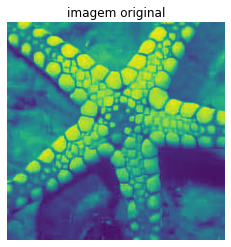


PSNR da imagem borrada: 21.196445197771023
Potência do filtro: 32


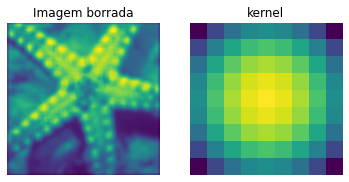

In [3]:
#---------------------------------------------------
# Módulo de borramento de imagem e criação de canais
#---------------------------------------------------

# Leitura da imgem original
im = cv2.imread('./starfish.jpeg', cv2.IMREAD_GRAYSCALE)

# Criação dos n canais gaussianos de forma iterativa
size_k  = 9
n       = 5
lo, hi  = (1, 20)
ker     = np.zeros((size_k, size_k))
sig     = np.random.randint(101)
blured_im = np.zeros(im.shape)

# Aplicação dos diferentes kerneis na imagem de referência
ker       = gen_gaussian_kernel(size_k, sig)
blured_im = signal.convolve2d(im, ker, mode="same")

#---------------------------------------------------------
# Impressão das imagens obtidas em comparação com original
#---------------------------------------------------------

plt.imshow(im)
plt.title("imagem original")
plt.axis("off")
plt.show()

# Confere tamanho adequado das imagens
print()
print(f"PSNR da imagem borrada: {calc_psnr(im, blured_im)}")
print(f"Potência do filtro: {sig}")

# Impressão dos resultados preliminares iniciais
plt.subplot(1, 2, 1)
plt.imshow(blured_im)
plt.title("Imagem borrada")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(ker)
plt.title("kernel")
plt.axis("off")
plt.show()

# Algoritmo genético com Filtro de Winer

## Funções:

In [67]:
#-----------------------------------------------------------------------
# Funções usadas para algoritmo genético e aplicação do filtro de Wiener
#-----------------------------------------------------------------------

def  generate_K (m, n):
    '''Geração de banco de sinais K de forma aleatória
       para geração de espaço de Kerneis pelo algoritmo
       genético.
       
       Relação de inputs:
        1 - m: Número de amostras no banco de genomas;
        2 - n: Comprimento da sequência aleatória.'''
    
    # Inicializa a matriz como estrutura de zeros
    K_bank = np.zeros((m, n))
    
    # Inicializa vetor de probabilidades
    P = np.random.uniform(0, 1, m)
    
    # Itera sobre cada amostra para determinação de sequência i.i.d.
    for ii, pr in enumerate(P):
        K_bank[ii, :] = np.random.choice(
            [0., 1.], 
            n, 
            p = [pr, 1 - pr]
        )
    
    return K_bank

def wiener_filter (R, K, shape):
    '''Função de determinação de matriz de filtro W.
       Estima-se W(u,v) a partir da equação:
           
       (1) w(u,v) = H(u,v)^-1 * |H(u,v)|^2 / (|H(u,v)|^2 + K)
       
       Relação de inputs:
        1 - R: Estimativa inicial de tamanho de raio da PSF;
        2 - K: Sequência gênica selecionada.'''
    
    # Inicializa matriz de filtro na memória
    W = np.zeros(shape)
    H = np.zeros(shape)
    
    # Declara variáveis de dimensões discretas dos filtros
    m, n = shape
    
    # Estima resposta do canal por meio de fç de Bessel
    for ii in range(m):
        for jj in range(n):
            r = np.sqrt(ii**2 + jj**2)
            if r == 0:
                H[ii, jj] = 1.
            elif r > R:
                H[ii, jj] = 0.
            else:
                H[ii, jj]  = special.jv(1, R * r)
                H[ii, jj] /= R * r
    
    # Calcula W em função de H e K, como em (1)
    W = np.conjugate(H) / (K + linalg.det(H)**2)
    return W

def score_calc (K_bank, diffs):
    '''Função de cálculo de score para uma determi-
       nada métrica mais ou menos adequada para o problema.
       
       Relação de inputs:
        1 - K_bank: Lista de genomas a ser avaliada.
        2 - diffs:  Lista de diferenças sucessivas encontradas para Ra e Rb'''
    
    # Inicializa variável de retorno
    score = np.zeros_like(diffs)
    tmp   = diff
    idx   = 0
    
    # Calcula de forma iterativa argumentos mínimos
    while len(tmp) != 0:
        score[idx] = np.argmin(tmp).item()
        tmp = np.delete(tmp, score[idx].astype(np.int32))
        idx += 1
    
    return score

def crossover (K_seq1, K_seq2, m=0.7):
    '''Função de efetuação de crossover para
       mutação genética para dadas duas sequências
       genômicas para o kernel K.
       
       Relação de inputs:
        1 - K_seq1: Primeira sequência genômica;
        2 - K_seq2: Segunda sequência genômica;
        3 - m=0.7:  Parâmetro de comprimento para sequência de troca.'''
    
    # Determinação de comprimento e índice de troca
    shp = K_seq1.shape
    if len(shp) == 2:
        n = shp[1]
    else:
        n = shp[0]
        
    idx  = np.int32(np.round(m * n) % n)
    
    # Executa mutação gênica entre ambas as sequências
    tmp  = K_seq1[idx:]
    K_seq1[idx:] = K_seq2[idx:]
    K_seq2[idx:] = tmp    
    return K_seq1, K_seq2

def next_gen (score, K_bank, nxt=5, p_cross=0.3):
    '''Função de atualização de genomas para a próxima 
       geração do algoritmo genético.
       
       Relação de inputs:
        1 - score:   Lista com scores obtidos na ordem dos índices dos genomas;
        2 - K_bank:  Lista de genomas usada para base da atualização;
        3 - nxt:     Número máximo de genomas selecionados p/ próx. geração;
        4 - p_cross: Probabilidade de se ocorrer um cross-over entre dois genomas.'''
    
    # Obtenção das dimensões da base de genomas
    m, n  = K_bank.shape
    K_nxt = np.zeros((m, n))
    
    # Inicia flag de verificação de crossover
    c_flag = False
    
    # Adquire índices de 5 maiores scores
    #idx = np.argsort(score)[(-1 * nxt):]
    idx = score[:nxt]
    
    # Atualiza genomas da próxima geração com os melhores da geração ant.
    #K_nxt[:nxt, :] = K_bank[idx.ravel(), :]
    K_nxt[:nxt, :] = K_bank[np.int32(idx.ravel()), :]
    
    # Inicia ciclo de crossover
    if (c := np.random.uniform(0, 1)) <= p_cross:
        idx_seq = np.random.randint(0, nxt)
        k1, kn  = crossover(
            K_nxt[0, :], 
            K_nxt[idx_seq, :], 
            m = 1 - c
        )
        K_nxt[0, :]       = k1
        K_nxt[idx_seq, :] = kn
        c_flag            = True
    
    # Determina resto da base a partir de população aletória de genomas
    K_nxt[nxt:, :] = generate_K(m - nxt, n)
    return K_nxt, c_flag

# Script de evolução

In [71]:
#----------------------------------------------------------------
# Implementação das iterações para gerações do algoritmo genético
#----------------------------------------------------------------

# Declaração das variáveis de controle usadas
m      = 500        # Número de indivíduos por geração
n      = 1000       # Número de amostras
nxt    = 50         # Número de indivíduos preservados 
k_max  = 150        # Número máximo de gerações
Ra     = 1          # Chute inicial para raio 1 --> 1 
Rb     = 20         # Chute inicial para raio 2 --> 5
k      = 0          # Contador de gerações
c_cnt  = 0          # Contador de crossovers
shape  = blured_im.shape

# Estimação das TF's das imagens envolvidas
F      = fft.fft2(blured_im)

# Geração inicial de banco de genomas
K_bank = generate_K(m, n)

# Início do loop principal do Algoritmo genético
while k < k_max:
    # Criação de listas específicas para cada iteração:
    diff   = np.zeros((m, 1))
    Ra_vec = np.zeros((m, 1))
    Rb_vec = np.zeros((m, 1))
    
    # Estimação de Ra' e Rb' para cada genoma associado
    for ii in range(m):
        # Cálculo dos parâmetros K e R
        K  = np.sum(K_bank[ii, :]) / n
        R  = (Ra + Rb) / 2
        
        # Cálculo de parâmtros de filtro para Ra
        Wa         = wiener_filter(Ra, K, shape)
        Fa         = np.multiply(F, Wa)                         # ! Por alguma razão, Wa[0, 0] = 0 
        Ra_p       = np.abs(Fa[0, 0] * Ra * (1 + K) / F[0, 0])  #   Sempre! Isso pode ter a ver com ser a pri-
        Ra_vec[ii] = Ra_p                                       #   meira iteração ou algo mais profundo...
        #Fa         = R * F[0, 0] / (Ra * (1 + K))
        #Ra_p       = np.abs(Fa * Ra * (1 + K) / F[0, 0])
        #Ra_vec[ii] = Ra_p
        
        # Cálculo de parâmtros de filtro para Rb
        Wb         = wiener_filter(Rb, K, shape)
        Fb         = np.multiply(F, Wb)
        Rb_p       = np.abs(Fb[0, 0] * Rb * (1 + K) / F[0, 0])
        Rb_vec[ii] = Rb_p
        #Fb         = R * F[0, 0] / (Rb * (1 + K))
        #Rb_p       = np.abs(Fb * Rb * (1 + K) / F[0, 0])
        #Rb_vec[ii] = Rb_p
        
        # Cálculo de diferença para cada etapa
        diff[ii] = np.abs(Ra_p - Rb_p)
                
        # DEBUG
        print("DEBUG")
        print(f"({ii, k}): (Wa, Wb) = {(np.max(Wa), np.max(Wb))}")
        
    # Cálculo de score para a geração
    score = score_calc(K_bank, diff)
    
    # Atualização do bano de gneomas a partir dos desempenhos
    K_bank, c_flag = next_gen(score, K_bank, nxt=nxt)
    
    # Atualiza os valores de Ra e Rb
    idx = np.argmax(score)
    Ra  = Ra_vec[idx]
    Rb  = Rb_vec[idx]
    
    # Incrementa contador de crossovers
    if c_flag == True:
        c_cnt += 1
    
    # Ciclo de impressão de resultados
    print()
    print(f"Melhor desempenho {k + 1}a geração:")
    #for jj in range(nxt):
    #    print(f"  K{jj}    = {np.sum(K_bank[jj, :]) / n}")
    
    print(f"  Ra_p    = {Ra_p}")
    print(f"  Rb_p    = {Rb_p}")
    print(f"crossover = {c_flag}")
    
    # Incrementa contador de gerações
    k += 1

# Cálculo de variáveis finais
R    = (Ra_p + Rb_p) / 2
K    = np.sum(K_bank[0, :]) / n
rate = c_cnt / k_max

# Impressão de grandezas obtidas
print()
print("------------------------------------------")
print("Algoritmo finalizado.")
print(f"R       = {R}")
print(f"sigma   = {np.sqrt(sig)}")
print(f"K       = {K}")
print(f"A taxa de execução de crossovers foi de {np.round(rate, 3)} para 150 gerações.")

DEBUG
((0, 0)): (Wa, Wb) = (50.0, 50.0)
DEBUG
((1, 0)): (Wa, Wb) = (1.1820330969267139, 1.1820330969267139)
DEBUG
((2, 0)): (Wa, Wb) = (2.277904328018223, 2.277904328018223)
DEBUG
((3, 0)): (Wa, Wb) = (1.0111223458038423, 1.0111223458038423)
DEBUG
((4, 0)): (Wa, Wb) = (1.8018018018018016, 1.8018018018018016)
DEBUG
((5, 0)): (Wa, Wb) = (4.132231404958678, 4.132231404958678)
DEBUG
((6, 0)): (Wa, Wb) = (1.4534883720930234, 1.4534883720930234)
DEBUG
((7, 0)): (Wa, Wb) = (21.73913043478261, 21.73913043478261)
DEBUG
((8, 0)): (Wa, Wb) = (1.3054830287206267, 1.3054830287206267)
DEBUG
((9, 0)): (Wa, Wb) = (1.0593220338983051, 1.0593220338983051)
DEBUG
((10, 0)): (Wa, Wb) = (17.543859649122805, 17.543859649122805)
DEBUG
((11, 0)): (Wa, Wb) = (16.129032258064516, 16.129032258064516)
DEBUG
((12, 0)): (Wa, Wb) = (1.1737089201877935, 1.1737089201877935)
DEBUG
((13, 0)): (Wa, Wb) = (1.297016861219196, 1.297016861219196)
DEBUG
((14, 0)): (Wa, Wb) = (1.721170395869191, 1.721170395869191)
DEBUG
((15, 0

DEBUG
((123, 0)): (Wa, Wb) = (1.4104372355430184, 1.4104372355430184)
DEBUG
((124, 0)): (Wa, Wb) = (1.0615711252653928, 1.0615711252653928)
DEBUG
((125, 0)): (Wa, Wb) = (1.51285930408472, 1.51285930408472)
DEBUG
((126, 0)): (Wa, Wb) = (1.7064846416382253, 1.7064846416382253)
DEBUG
((127, 0)): (Wa, Wb) = (1.2406947890818858, 1.2406947890818858)
DEBUG
((128, 0)): (Wa, Wb) = (1.1049723756906078, 1.1049723756906078)
DEBUG
((129, 0)): (Wa, Wb) = (1.3513513513513513, 1.3513513513513513)
DEBUG
((130, 0)): (Wa, Wb) = (2.7548209366391188, 2.7548209366391188)
DEBUG
((131, 0)): (Wa, Wb) = (1.7123287671232879, 1.7123287671232879)
DEBUG
((132, 0)): (Wa, Wb) = (1.7953321364452421, 1.7953321364452421)
DEBUG
((133, 0)): (Wa, Wb) = (5.58659217877095, 5.58659217877095)
DEBUG
((134, 0)): (Wa, Wb) = (1.1695906432748537, 1.1695906432748537)
DEBUG
((135, 0)): (Wa, Wb) = (13.513513513513514, 13.513513513513514)
DEBUG
((136, 0)): (Wa, Wb) = (90.90909090909092, 90.90909090909092)
DEBUG
((137, 0)): (Wa, Wb) = (

DEBUG
((243, 0)): (Wa, Wb) = (1.310615989515072, 1.310615989515072)
DEBUG
((244, 0)): (Wa, Wb) = (1.7301038062283738, 1.7301038062283738)
DEBUG
((245, 0)): (Wa, Wb) = (1.0471204188481675, 1.0471204188481675)
DEBUG
((246, 0)): (Wa, Wb) = (1.1820330969267139, 1.1820330969267139)
DEBUG
((247, 0)): (Wa, Wb) = (1.1494252873563218, 1.1494252873563218)
DEBUG
((248, 0)): (Wa, Wb) = (1.7421602787456447, 1.7421602787456447)
DEBUG
((249, 0)): (Wa, Wb) = (1.5649452269170578, 1.5649452269170578)
DEBUG
((250, 0)): (Wa, Wb) = (3.7037037037037033, 3.7037037037037033)
DEBUG
((251, 0)): (Wa, Wb) = (111.11111111111111, 111.11111111111111)
DEBUG
((252, 0)): (Wa, Wb) = (1.9305019305019304, 1.9305019305019304)
DEBUG
((253, 0)): (Wa, Wb) = (1.2903225806451613, 1.2903225806451613)
DEBUG
((254, 0)): (Wa, Wb) = (4.424778761061947, 4.424778761061947)
DEBUG
((255, 0)): (Wa, Wb) = (1.721170395869191, 1.721170395869191)
DEBUG
((256, 0)): (Wa, Wb) = (2.0080321285140563, 2.0080321285140563)
DEBUG
((257, 0)): (Wa, Wb)

DEBUG
((363, 0)): (Wa, Wb) = (1.081081081081081, 1.081081081081081)
DEBUG
((364, 0)): (Wa, Wb) = (1.0341261633919339, 1.0341261633919339)
DEBUG
((365, 0)): (Wa, Wb) = (7.462686567164178, 7.462686567164178)
DEBUG
((366, 0)): (Wa, Wb) = (1.3440860215053763, 1.3440860215053763)
DEBUG
((367, 0)): (Wa, Wb) = (1.2269938650306749, 1.2269938650306749)
DEBUG
((368, 0)): (Wa, Wb) = (2.247191011235955, 2.247191011235955)
DEBUG
((369, 0)): (Wa, Wb) = (3.875968992248062, 3.875968992248062)
DEBUG
((370, 0)): (Wa, Wb) = (3.0303030303030303, 3.0303030303030303)
DEBUG
((371, 0)): (Wa, Wb) = (4.25531914893617, 4.25531914893617)
DEBUG
((372, 0)): (Wa, Wb) = (2.053388090349076, 2.053388090349076)
DEBUG
((373, 0)): (Wa, Wb) = (9.090909090909092, 9.090909090909092)
DEBUG
((374, 0)): (Wa, Wb) = (1.2422360248447204, 1.2422360248447204)
DEBUG
((375, 0)): (Wa, Wb) = (1.5174506828528072, 1.5174506828528072)
DEBUG
((376, 0)): (Wa, Wb) = (2.3255813953488373, 2.3255813953488373)
DEBUG
((377, 0)): (Wa, Wb) = (3.8610

DEBUG
((484, 0)): (Wa, Wb) = (2.9850746268656714, 2.9850746268656714)
DEBUG
((485, 0)): (Wa, Wb) = (5.74712643678161, 5.74712643678161)
DEBUG
((486, 0)): (Wa, Wb) = (2.0964360587002098, 2.0964360587002098)
DEBUG
((487, 0)): (Wa, Wb) = (2.976190476190476, 2.976190476190476)
DEBUG
((488, 0)): (Wa, Wb) = (2.247191011235955, 2.247191011235955)
DEBUG
((489, 0)): (Wa, Wb) = (2.4570024570024573, 2.4570024570024573)
DEBUG
((490, 0)): (Wa, Wb) = (1.5337423312883436, 1.5337423312883436)
DEBUG
((491, 0)): (Wa, Wb) = (1.0940919037199124, 1.0940919037199124)
DEBUG
((492, 0)): (Wa, Wb) = (90.90909090909092, 90.90909090909092)
DEBUG
((493, 0)): (Wa, Wb) = (10.416666666666666, 10.416666666666666)
DEBUG
((494, 0)): (Wa, Wb) = (1.6, 1.6)
DEBUG
((495, 0)): (Wa, Wb) = (1.231527093596059, 1.231527093596059)
DEBUG
((496, 0)): (Wa, Wb) = (2.6246719160104988, 2.6246719160104988)
DEBUG
((497, 0)): (Wa, Wb) = (1.0857763300760044, 1.0857763300760044)
DEBUG
((498, 0)): (Wa, Wb) = (2.028397565922921, 2.02839756592

DEBUG
((104, 1)): (Wa, Wb) = (5.208333333333333, 5.208333333333333)
DEBUG
((105, 1)): (Wa, Wb) = (3.278688524590164, 3.278688524590164)
DEBUG
((106, 1)): (Wa, Wb) = (2.7247956403269757, 2.7247956403269757)
DEBUG
((107, 1)): (Wa, Wb) = (1.2269938650306749, 1.2269938650306749)
DEBUG
((108, 1)): (Wa, Wb) = (1.287001287001287, 1.287001287001287)
DEBUG
((109, 1)): (Wa, Wb) = (1.2224938875305624, 1.2224938875305624)
DEBUG
((110, 1)): (Wa, Wb) = (3.558718861209964, 3.558718861209964)
DEBUG
((111, 1)): (Wa, Wb) = (2.1186440677966103, 2.1186440677966103)
DEBUG
((112, 1)): (Wa, Wb) = (14.925373134328357, 14.925373134328357)
DEBUG
((113, 1)): (Wa, Wb) = (5.208333333333333, 5.208333333333333)
DEBUG
((114, 1)): (Wa, Wb) = (1.282051282051282, 1.282051282051282)
DEBUG
((115, 1)): (Wa, Wb) = (1.718213058419244, 1.718213058419244)
DEBUG
((116, 1)): (Wa, Wb) = (1.5337423312883436, 1.5337423312883436)
DEBUG
((117, 1)): (Wa, Wb) = (6.756756756756757, 6.756756756756757)
DEBUG
((118, 1)): (Wa, Wb) = (2.1097

DEBUG
((224, 1)): (Wa, Wb) = (1.3368983957219251, 1.3368983957219251)
DEBUG
((225, 1)): (Wa, Wb) = (250.0, 250.0)
DEBUG
((226, 1)): (Wa, Wb) = (3.4482758620689657, 3.4482758620689657)
DEBUG
((227, 1)): (Wa, Wb) = (2.6246719160104988, 2.6246719160104988)
DEBUG
((228, 1)): (Wa, Wb) = (1.6025641025641026, 1.6025641025641026)
DEBUG
((229, 1)): (Wa, Wb) = (1.0928961748633879, 1.0928961748633879)
DEBUG
((230, 1)): (Wa, Wb) = (6.4935064935064934, 6.4935064935064934)
DEBUG
((231, 1)): (Wa, Wb) = (4.901960784313726, 4.901960784313726)
DEBUG
((232, 1)): (Wa, Wb) = (1.3717421124828533, 1.3717421124828533)
DEBUG
((233, 1)): (Wa, Wb) = (1.8518518518518516, 1.8518518518518516)
DEBUG
((234, 1)): (Wa, Wb) = (1.1723329425556859, 1.1723329425556859)
DEBUG
((235, 1)): (Wa, Wb) = (1.6778523489932886, 1.6778523489932886)
DEBUG
((236, 1)): (Wa, Wb) = (20.833333333333332, 20.833333333333332)
DEBUG
((237, 1)): (Wa, Wb) = (1.1061946902654867, 1.1061946902654867)
DEBUG
((238, 1)): (Wa, Wb) = (1.6129032258064517

DEBUG
((344, 1)): (Wa, Wb) = (5.128205128205128, 5.128205128205128)
DEBUG
((345, 1)): (Wa, Wb) = (1.2578616352201257, 1.2578616352201257)
DEBUG
((346, 1)): (Wa, Wb) = (1.8281535648994514, 1.8281535648994514)
DEBUG
((347, 1)): (Wa, Wb) = (1.1641443538998837, 1.1641443538998837)
DEBUG
((348, 1)): (Wa, Wb) = (1.1415525114155252, 1.1415525114155252)
DEBUG
((349, 1)): (Wa, Wb) = (1.7452006980802794, 1.7452006980802794)
DEBUG
((350, 1)): (Wa, Wb) = (1.9083969465648853, 1.9083969465648853)
DEBUG
((351, 1)): (Wa, Wb) = (43.47826086956522, 43.47826086956522)
DEBUG
((352, 1)): (Wa, Wb) = (2.4038461538461537, 2.4038461538461537)
DEBUG
((353, 1)): (Wa, Wb) = (1.4388489208633095, 1.4388489208633095)
DEBUG
((354, 1)): (Wa, Wb) = (3.663003663003663, 3.663003663003663)
DEBUG
((355, 1)): (Wa, Wb) = (2.785515320334262, 2.785515320334262)
DEBUG
((356, 1)): (Wa, Wb) = (1.1494252873563218, 1.1494252873563218)
DEBUG
((357, 1)): (Wa, Wb) = (1.070663811563169, 1.070663811563169)
DEBUG
((358, 1)): (Wa, Wb) = (

DEBUG
((463, 1)): (Wa, Wb) = (3.717472118959108, 3.717472118959108)
DEBUG
((464, 1)): (Wa, Wb) = (9.900990099009901, 9.900990099009901)
DEBUG
((465, 1)): (Wa, Wb) = (1.0857763300760044, 1.0857763300760044)
DEBUG
((466, 1)): (Wa, Wb) = (1.0438413361169103, 1.0438413361169103)
DEBUG
((467, 1)): (Wa, Wb) = (1.1148272017837235, 1.1148272017837235)
DEBUG
((468, 1)): (Wa, Wb) = (1.1990407673860912, 1.1990407673860912)
DEBUG
((469, 1)): (Wa, Wb) = (1.1918951132300357, 1.1918951132300357)
DEBUG
((470, 1)): (Wa, Wb) = (250.0, 250.0)
DEBUG
((471, 1)): (Wa, Wb) = (1.3831258644536653, 1.3831258644536653)
DEBUG
((472, 1)): (Wa, Wb) = (1.4471780028943562, 1.4471780028943562)
DEBUG
((473, 1)): (Wa, Wb) = (2.5, 2.5)
DEBUG
((474, 1)): (Wa, Wb) = (1.2642225031605563, 1.2642225031605563)
DEBUG
((475, 1)): (Wa, Wb) = (1.0080645161290323, 1.0080645161290323)
DEBUG
((476, 1)): (Wa, Wb) = (1.2195121951219512, 1.2195121951219512)
DEBUG
((477, 1)): (Wa, Wb) = (1.3192612137203166, 1.3192612137203166)
DEBUG
((47

DEBUG
((84, 2)): (Wa, Wb) = (1.0224948875255624, 1.0224948875255624)
DEBUG
((85, 2)): (Wa, Wb) = (7.751937984496124, 7.751937984496124)
DEBUG
((86, 2)): (Wa, Wb) = (2.2831050228310503, 2.2831050228310503)
DEBUG
((87, 2)): (Wa, Wb) = (11.11111111111111, 11.11111111111111)
DEBUG
((88, 2)): (Wa, Wb) = (2.8328611898017, 2.8328611898017)
DEBUG
((89, 2)): (Wa, Wb) = (3.861003861003861, 3.861003861003861)
DEBUG
((90, 2)): (Wa, Wb) = (1.1013215859030836, 1.1013215859030836)
DEBUG
((91, 2)): (Wa, Wb) = (2.5773195876288657, 2.5773195876288657)
DEBUG
((92, 2)): (Wa, Wb) = (5.154639175257731, 5.154639175257731)
DEBUG
((93, 2)): (Wa, Wb) = (1.0351966873706004, 1.0351966873706004)
DEBUG
((94, 2)): (Wa, Wb) = (4.62962962962963, 4.62962962962963)
DEBUG
((95, 2)): (Wa, Wb) = (1.7574692442882252, 1.7574692442882252)
DEBUG
((96, 2)): (Wa, Wb) = (3.4246575342465757, 3.4246575342465757)
DEBUG
((97, 2)): (Wa, Wb) = (2.109704641350211, 2.109704641350211)
DEBUG
((98, 2)): (Wa, Wb) = (3.745318352059925, 3.7453

DEBUG
((204, 2)): (Wa, Wb) = (1.6556291390728477, 1.6556291390728477)
DEBUG
((205, 2)): (Wa, Wb) = (4.0, 4.0)
DEBUG
((206, 2)): (Wa, Wb) = (2.320185614849188, 2.320185614849188)
DEBUG
((207, 2)): (Wa, Wb) = (3.731343283582089, 3.731343283582089)
DEBUG
((208, 2)): (Wa, Wb) = (1.1961722488038278, 1.1961722488038278)
DEBUG
((209, 2)): (Wa, Wb) = (5.847953216374268, 5.847953216374268)
DEBUG
((210, 2)): (Wa, Wb) = (3.937007874015748, 3.937007874015748)
DEBUG
((211, 2)): (Wa, Wb) = (1.2562814070351758, 1.2562814070351758)
DEBUG
((212, 2)): (Wa, Wb) = (1.5847860538827259, 1.5847860538827259)
DEBUG
((213, 2)): (Wa, Wb) = (3.717472118959108, 3.717472118959108)
DEBUG
((214, 2)): (Wa, Wb) = (3.4013605442176873, 3.4013605442176873)
DEBUG
((215, 2)): (Wa, Wb) = (2.4038461538461537, 2.4038461538461537)
DEBUG
((216, 2)): (Wa, Wb) = (1.9305019305019304, 1.9305019305019304)
DEBUG
((217, 2)): (Wa, Wb) = (4.366812227074235, 4.366812227074235)
DEBUG
((218, 2)): (Wa, Wb) = (1.044932079414838, 1.04493207941

DEBUG
((324, 2)): (Wa, Wb) = (2.109704641350211, 2.109704641350211)
DEBUG
((325, 2)): (Wa, Wb) = (2.247191011235955, 2.247191011235955)
DEBUG
((326, 2)): (Wa, Wb) = (1.0309278350515465, 1.0309278350515465)
DEBUG
((327, 2)): (Wa, Wb) = (1.2422360248447204, 1.2422360248447204)
DEBUG
((328, 2)): (Wa, Wb) = (1.3458950201884252, 1.3458950201884252)
DEBUG
((329, 2)): (Wa, Wb) = (12.345679012345679, 12.345679012345679)
DEBUG
((330, 2)): (Wa, Wb) = (1.6025641025641026, 1.6025641025641026)
DEBUG
((331, 2)): (Wa, Wb) = (1.278772378516624, 1.278772378516624)
DEBUG
((332, 2)): (Wa, Wb) = (2.9585798816568047, 2.9585798816568047)
DEBUG
((333, 2)): (Wa, Wb) = (2.100840336134454, 2.100840336134454)
DEBUG
((334, 2)): (Wa, Wb) = (1.5527950310559007, 1.5527950310559007)
DEBUG
((335, 2)): (Wa, Wb) = (1.402524544179523, 1.402524544179523)
DEBUG
((336, 2)): (Wa, Wb) = (1.3054830287206267, 1.3054830287206267)
DEBUG
((337, 2)): (Wa, Wb) = (1.8726591760299625, 1.8726591760299625)
DEBUG
((338, 2)): (Wa, Wb) = (

DEBUG
((443, 2)): (Wa, Wb) = (2.638522427440633, 2.638522427440633)
DEBUG
((444, 2)): (Wa, Wb) = (1.3477088948787062, 1.3477088948787062)
DEBUG
((445, 2)): (Wa, Wb) = (1.0, 1.0)
DEBUG
((446, 2)): (Wa, Wb) = (1.0438413361169103, 1.0438413361169103)
DEBUG
((447, 2)): (Wa, Wb) = (1.1061946902654867, 1.1061946902654867)
DEBUG
((448, 2)): (Wa, Wb) = (5.988023952095808, 5.988023952095808)
DEBUG
((449, 2)): (Wa, Wb) = (1.402524544179523, 1.402524544179523)
DEBUG
((450, 2)): (Wa, Wb) = (7.633587786259541, 7.633587786259541)
DEBUG
((451, 2)): (Wa, Wb) = (6.622516556291391, 6.622516556291391)
DEBUG
((452, 2)): (Wa, Wb) = (4.132231404958678, 4.132231404958678)
DEBUG
((453, 2)): (Wa, Wb) = (3.663003663003663, 3.663003663003663)
DEBUG
((454, 2)): (Wa, Wb) = (1.3386880856760375, 1.3386880856760375)
DEBUG
((455, 2)): (Wa, Wb) = (8.695652173913043, 8.695652173913043)
DEBUG
((456, 2)): (Wa, Wb) = (1.2738853503184713, 1.2738853503184713)
DEBUG
((457, 2)): (Wa, Wb) = (3.745318352059925, 3.745318352059925

DEBUG
((62, 3)): (Wa, Wb) = (10.869565217391305, 10.869565217391305)
DEBUG
((63, 3)): (Wa, Wb) = (3.4013605442176873, 3.4013605442176873)
DEBUG
((64, 3)): (Wa, Wb) = (2.1321961620469083, 2.1321961620469083)
DEBUG
((65, 3)): (Wa, Wb) = (1.6750418760469012, 1.6750418760469012)
DEBUG
((66, 3)): (Wa, Wb) = (1.1428571428571428, 1.1428571428571428)
DEBUG
((67, 3)): (Wa, Wb) = (1.079913606911447, 1.079913606911447)
DEBUG
((68, 3)): (Wa, Wb) = (1.5432098765432098, 1.5432098765432098)
DEBUG
((69, 3)): (Wa, Wb) = (1.0030090270812437, 1.0030090270812437)
DEBUG
((70, 3)): (Wa, Wb) = (1.400560224089636, 1.400560224089636)
DEBUG
((71, 3)): (Wa, Wb) = (1.4245014245014247, 1.4245014245014247)
DEBUG
((72, 3)): (Wa, Wb) = (16.39344262295082, 16.39344262295082)
DEBUG
((73, 3)): (Wa, Wb) = (2.0161290322580645, 2.0161290322580645)
DEBUG
((74, 3)): (Wa, Wb) = (1.7391304347826089, 1.7391304347826089)
DEBUG
((75, 3)): (Wa, Wb) = (5.813953488372094, 5.813953488372094)
DEBUG
((76, 3)): (Wa, Wb) = (4.97512437810

DEBUG
((182, 3)): (Wa, Wb) = (12.987012987012987, 12.987012987012987)
DEBUG
((183, 3)): (Wa, Wb) = (1.8656716417910446, 1.8656716417910446)
DEBUG
((184, 3)): (Wa, Wb) = (3.546099290780142, 3.546099290780142)
DEBUG
((185, 3)): (Wa, Wb) = (4.237288135593221, 4.237288135593221)
DEBUG
((186, 3)): (Wa, Wb) = (4.672897196261682, 4.672897196261682)
DEBUG
((187, 3)): (Wa, Wb) = (2.824858757062147, 2.824858757062147)
DEBUG
((188, 3)): (Wa, Wb) = (2.109704641350211, 2.109704641350211)
DEBUG
((189, 3)): (Wa, Wb) = (2.941176470588235, 2.941176470588235)
DEBUG
((190, 3)): (Wa, Wb) = (6.211180124223603, 6.211180124223603)
DEBUG
((191, 3)): (Wa, Wb) = (2.0080321285140563, 2.0080321285140563)
DEBUG
((192, 3)): (Wa, Wb) = (2.4691358024691357, 2.4691358024691357)
DEBUG
((193, 3)): (Wa, Wb) = (6.622516556291391, 6.622516556291391)
DEBUG
((194, 3)): (Wa, Wb) = (2.032520325203252, 2.032520325203252)
DEBUG
((195, 3)): (Wa, Wb) = (2.3529411764705883, 2.3529411764705883)
DEBUG
((196, 3)): (Wa, Wb) = (2.932551

/tmp/ipykernel_7019/1626405782.py:60: RuntimeWarning: divide by zero encountered in true_divide
  W = np.conjugate(H) / (K + linalg.det(H)**2)
/tmp/ipykernel_7019/1626405782.py:60: RuntimeWarning: invalid value encountered in true_divide
  W = np.conjugate(H) / (K + linalg.det(H)**2)
/tmp/ipykernel_7019/3638514816.py:37: RuntimeWarning: invalid value encountered in multiply
  Fa         = np.multiply(F, Wa)                         # ! Por alguma razão, Wa[0, 0] = 0
/tmp/ipykernel_7019/3638514816.py:38: RuntimeWarning: invalid value encountered in multiply
  Ra_p       = np.abs(Fa[0, 0] * Ra * (1 + K) / F[0, 0])  #   Sempre! Isso pode ter a ver com ser a pri-
/tmp/ipykernel_7019/3638514816.py:46: RuntimeWarning: invalid value encountered in multiply
  Fb         = np.multiply(F, Wb)
/tmp/ipykernel_7019/3638514816.py:47: RuntimeWarning: invalid value encountered in multiply
  Rb_p       = np.abs(Fb[0, 0] * Rb * (1 + K) / F[0, 0])


DEBUG
((271, 3)): (Wa, Wb) = (nan, nan)
DEBUG
((272, 3)): (Wa, Wb) = (2.5974025974025974, 2.5974025974025974)
DEBUG
((273, 3)): (Wa, Wb) = (1000.0, 1000.0)
DEBUG
((274, 3)): (Wa, Wb) = (1.0362694300518136, 1.0362694300518136)
DEBUG
((275, 3)): (Wa, Wb) = (7.042253521126761, 7.042253521126761)
DEBUG
((276, 3)): (Wa, Wb) = (2.320185614849188, 2.320185614849188)
DEBUG
((277, 3)): (Wa, Wb) = (7.352941176470588, 7.352941176470588)
DEBUG
((278, 3)): (Wa, Wb) = (12.987012987012987, 12.987012987012987)
DEBUG
((279, 3)): (Wa, Wb) = (1.050420168067227, 1.050420168067227)
DEBUG
((280, 3)): (Wa, Wb) = (2.717391304347826, 2.717391304347826)
DEBUG
((281, 3)): (Wa, Wb) = (1.7857142857142856, 1.7857142857142856)
DEBUG
((282, 3)): (Wa, Wb) = (1.4858841010401187, 1.4858841010401187)
DEBUG
((283, 3)): (Wa, Wb) = (1.0845986984815619, 1.0845986984815619)
DEBUG
((284, 3)): (Wa, Wb) = (3.3444816053511706, 3.3444816053511706)
DEBUG
((285, 3)): (Wa, Wb) = (6.666666666666667, 6.666666666666667)
DEBUG
((286, 3))

DEBUG
((391, 3)): (Wa, Wb) = (1.1441647597254005, 1.1441647597254005)
DEBUG
((392, 3)): (Wa, Wb) = (1.779359430604982, 1.779359430604982)
DEBUG
((393, 3)): (Wa, Wb) = (1.3280212483399734, 1.3280212483399734)
DEBUG
((394, 3)): (Wa, Wb) = (41.666666666666664, 41.666666666666664)
DEBUG
((395, 3)): (Wa, Wb) = (2.808988764044944, 2.808988764044944)
DEBUG
((396, 3)): (Wa, Wb) = (1.1560693641618498, 1.1560693641618498)
DEBUG
((397, 3)): (Wa, Wb) = (1.7271157167530227, 1.7271157167530227)
DEBUG
((398, 3)): (Wa, Wb) = (1.41643059490085, 1.41643059490085)
DEBUG
((399, 3)): (Wa, Wb) = (1.3679890560875514, 1.3679890560875514)
DEBUG
((400, 3)): (Wa, Wb) = (1.5313935681470137, 1.5313935681470137)
DEBUG
((401, 3)): (Wa, Wb) = (1.1160714285714286, 1.1160714285714286)
DEBUG
((402, 3)): (Wa, Wb) = (1.461988304093567, 1.461988304093567)
DEBUG
((403, 3)): (Wa, Wb) = (1.6181229773462784, 1.6181229773462784)
DEBUG
((404, 3)): (Wa, Wb) = (1.0060362173038229, 1.0060362173038229)
DEBUG
((405, 3)): (Wa, Wb) = (

DEBUG
((11, 4)): (Wa, Wb) = (1.3679890560875514, 1.3679890560875514)
DEBUG
((12, 4)): (Wa, Wb) = (1.0683760683760684, 1.0683760683760684)
DEBUG
((13, 4)): (Wa, Wb) = (5.813953488372094, 5.813953488372094)
DEBUG
((14, 4)): (Wa, Wb) = (26.315789473684212, 26.315789473684212)
DEBUG
((15, 4)): (Wa, Wb) = (1.6528925619834711, 1.6528925619834711)
DEBUG
((16, 4)): (Wa, Wb) = (5.524861878453039, 5.524861878453039)
DEBUG
((17, 4)): (Wa, Wb) = (1.0030090270812437, 1.0030090270812437)
DEBUG
((18, 4)): (Wa, Wb) = (1.9157088122605364, 1.9157088122605364)
DEBUG
((19, 4)): (Wa, Wb) = (6.4935064935064934, 6.4935064935064934)
DEBUG
((20, 4)): (Wa, Wb) = (6.451612903225807, 6.451612903225807)
DEBUG
((21, 4)): (Wa, Wb) = (8.19672131147541, 8.19672131147541)
DEBUG
((22, 4)): (Wa, Wb) = (1.2406947890818858, 1.2406947890818858)
DEBUG
((23, 4)): (Wa, Wb) = (1.4598540145985401, 1.4598540145985401)
DEBUG
((24, 4)): (Wa, Wb) = (6.211180124223603, 6.211180124223603)
DEBUG
((25, 4)): (Wa, Wb) = (6.849315068493151

DEBUG
((132, 4)): (Wa, Wb) = (1.0131712259371835, 1.0131712259371835)
DEBUG
((133, 4)): (Wa, Wb) = (2.680965147453083, 2.680965147453083)
DEBUG
((134, 4)): (Wa, Wb) = (2.375296912114014, 2.375296912114014)
DEBUG
((135, 4)): (Wa, Wb) = (1.1111111111111112, 1.1111111111111112)
DEBUG
((136, 4)): (Wa, Wb) = (12.820512820512821, 12.820512820512821)
DEBUG
((137, 4)): (Wa, Wb) = (2.6178010471204187, 2.6178010471204187)
DEBUG
((138, 4)): (Wa, Wb) = (1.5797788309636651, 1.5797788309636651)
DEBUG
((139, 4)): (Wa, Wb) = (24.390243902439025, 24.390243902439025)
DEBUG
((140, 4)): (Wa, Wb) = (2.487562189054726, 2.487562189054726)
DEBUG
((141, 4)): (Wa, Wb) = (11.627906976744187, 11.627906976744187)
DEBUG
((142, 4)): (Wa, Wb) = (4.739336492890995, 4.739336492890995)
DEBUG
((143, 4)): (Wa, Wb) = (1.6207455429497568, 1.6207455429497568)
DEBUG
((144, 4)): (Wa, Wb) = (1.303780964797914, 1.303780964797914)
DEBUG
((145, 4)): (Wa, Wb) = (1.4492753623188408, 1.4492753623188408)
DEBUG
((146, 4)): (Wa, Wb) = (

DEBUG
((254, 4)): (Wa, Wb) = (1.1494252873563218, 1.1494252873563218)
DEBUG
((255, 4)): (Wa, Wb) = (1.6103059581320451, 1.6103059581320451)
DEBUG
((256, 4)): (Wa, Wb) = (4.291845493562231, 4.291845493562231)
DEBUG
((257, 4)): (Wa, Wb) = (2.994011976047904, 2.994011976047904)
DEBUG
((258, 4)): (Wa, Wb) = (10.638297872340425, 10.638297872340425)
DEBUG
((259, 4)): (Wa, Wb) = (1.2468827930174562, 1.2468827930174562)
DEBUG
((260, 4)): (Wa, Wb) = (1.314060446780552, 1.314060446780552)
DEBUG
((261, 4)): (Wa, Wb) = (1.2077294685990339, 1.2077294685990339)
DEBUG
((262, 4)): (Wa, Wb) = (1.124859392575928, 1.124859392575928)
DEBUG
((263, 4)): (Wa, Wb) = (2.680965147453083, 2.680965147453083)
DEBUG
((264, 4)): (Wa, Wb) = (22.72727272727273, 22.72727272727273)
DEBUG
((265, 4)): (Wa, Wb) = (1.0672358591248665, 1.0672358591248665)
DEBUG
((266, 4)): (Wa, Wb) = (1.1695906432748537, 1.1695906432748537)
DEBUG
((267, 4)): (Wa, Wb) = (2.1978021978021975, 2.1978021978021975)
DEBUG
((268, 4)): (Wa, Wb) = (8.

DEBUG
((374, 4)): (Wa, Wb) = (16.39344262295082, 16.39344262295082)
DEBUG
((375, 4)): (Wa, Wb) = (3.0769230769230766, 3.0769230769230766)
DEBUG
((376, 4)): (Wa, Wb) = (2.8328611898017, 2.8328611898017)
DEBUG
((377, 4)): (Wa, Wb) = (2.7247956403269757, 2.7247956403269757)
DEBUG
((378, 4)): (Wa, Wb) = (9.090909090909092, 9.090909090909092)
DEBUG
((379, 4)): (Wa, Wb) = (1.4727540500736376, 1.4727540500736376)
DEBUG
((380, 4)): (Wa, Wb) = (14.705882352941176, 14.705882352941176)
DEBUG
((381, 4)): (Wa, Wb) = (1.019367991845056, 1.019367991845056)
DEBUG
((382, 4)): (Wa, Wb) = (4.25531914893617, 4.25531914893617)
DEBUG
((383, 4)): (Wa, Wb) = (16.129032258064516, 16.129032258064516)
DEBUG
((384, 4)): (Wa, Wb) = (19.23076923076923, 19.23076923076923)
DEBUG
((385, 4)): (Wa, Wb) = (8.695652173913043, 8.695652173913043)
DEBUG
((386, 4)): (Wa, Wb) = (1.2594458438287153, 1.2594458438287153)
DEBUG
((387, 4)): (Wa, Wb) = (5.405405405405405, 5.405405405405405)
DEBUG
((388, 4)): (Wa, Wb) = (1.1750881316

DEBUG
((494, 4)): (Wa, Wb) = (2.178649237472767, 2.178649237472767)
DEBUG
((495, 4)): (Wa, Wb) = (1.6313213703099512, 1.6313213703099512)
DEBUG
((496, 4)): (Wa, Wb) = (1.6666666666666667, 1.6666666666666667)
DEBUG
((497, 4)): (Wa, Wb) = (3.095975232198142, 3.095975232198142)
DEBUG
((498, 4)): (Wa, Wb) = (2.7247956403269757, 2.7247956403269757)
DEBUG
((499, 4)): (Wa, Wb) = (333.3333333333333, 333.3333333333333)

Melhor desempenho 5a geração:
  Ra_p    = [10171.17723024]
  Rb_p    = [203423.54460474]
crossover = False
DEBUG
((0, 5)): (Wa, Wb) = (nan, inf)
DEBUG
((1, 5)): (Wa, Wb) = (2.314814814814815, 2.314814814814815)
DEBUG
((2, 5)): (Wa, Wb) = (nan, inf)
DEBUG
((3, 5)): (Wa, Wb) = (1.375515818431912, 1.375515818431912)
DEBUG
((4, 5)): (Wa, Wb) = (1.6528925619834711, 1.6528925619834711)
DEBUG
((5, 5)): (Wa, Wb) = (2.487562189054726, 2.487562189054726)
DEBUG
((6, 5)): (Wa, Wb) = (2.34192037470726, 2.34192037470726)
DEBUG
((7, 5)): (Wa, Wb) = (1.1312217194570136, 1.1312217194570136)
DEBU

DEBUG
((115, 5)): (Wa, Wb) = (2.0833333333333335, 2.0833333333333335)
DEBUG
((116, 5)): (Wa, Wb) = (1.1806375442739079, 1.1806375442739079)
DEBUG
((117, 5)): (Wa, Wb) = (1.0917030567685588, 1.0917030567685588)
DEBUG
((118, 5)): (Wa, Wb) = (1.6420361247947455, 1.6420361247947455)
DEBUG
((119, 5)): (Wa, Wb) = (1.8796992481203008, 1.8796992481203008)
DEBUG
((120, 5)): (Wa, Wb) = (1.6420361247947455, 1.6420361247947455)
DEBUG
((121, 5)): (Wa, Wb) = (1.8018018018018016, 1.8018018018018016)
DEBUG
((122, 5)): (Wa, Wb) = (1.342281879194631, 1.342281879194631)
DEBUG
((123, 5)): (Wa, Wb) = (5.0761421319796955, 5.0761421319796955)
DEBUG
((124, 5)): (Wa, Wb) = (1.6474464579901154, 1.6474464579901154)
DEBUG
((125, 5)): (Wa, Wb) = (3.9215686274509802, 3.9215686274509802)
DEBUG
((126, 5)): (Wa, Wb) = (4.424778761061947, 4.424778761061947)
DEBUG
((127, 5)): (Wa, Wb) = (1.718213058419244, 1.718213058419244)
DEBUG
((128, 5)): (Wa, Wb) = (1.976284584980237, 1.976284584980237)
DEBUG
((129, 5)): (Wa, Wb) =

DEBUG
((235, 5)): (Wa, Wb) = (17.241379310344826, 17.241379310344826)
DEBUG
((236, 5)): (Wa, Wb) = (1.9193857965451055, 1.9193857965451055)
DEBUG
((237, 5)): (Wa, Wb) = (25.0, 25.0)
DEBUG
((238, 5)): (Wa, Wb) = (1.76678445229682, 1.76678445229682)
DEBUG
((239, 5)): (Wa, Wb) = (1.0729613733905579, 1.0729613733905579)
DEBUG
((240, 5)): (Wa, Wb) = (1.7889087656529514, 1.7889087656529514)
DEBUG
((241, 5)): (Wa, Wb) = (1.146788990825688, 1.146788990825688)
DEBUG
((242, 5)): (Wa, Wb) = (1.7035775127768313, 1.7035775127768313)
DEBUG
((243, 5)): (Wa, Wb) = (1.0141987829614605, 1.0141987829614605)
DEBUG
((244, 5)): (Wa, Wb) = (1.680672268907563, 1.680672268907563)
DEBUG
((245, 5)): (Wa, Wb) = (8.403361344537815, 8.403361344537815)
DEBUG
((246, 5)): (Wa, Wb) = (1.1415525114155252, 1.1415525114155252)
DEBUG
((247, 5)): (Wa, Wb) = (1.1337868480725624, 1.1337868480725624)
DEBUG
((248, 5)): (Wa, Wb) = (1.4104372355430184, 1.4104372355430184)
DEBUG
((249, 5)): (Wa, Wb) = (9.900990099009901, 9.9009900

DEBUG
((355, 5)): (Wa, Wb) = (3.021148036253776, 3.021148036253776)
DEBUG
((356, 5)): (Wa, Wb) = (2.5, 2.5)
DEBUG
((357, 5)): (Wa, Wb) = (1.858736059479554, 1.858736059479554)
DEBUG
((358, 5)): (Wa, Wb) = (3.4246575342465757, 3.4246575342465757)
DEBUG
((359, 5)): (Wa, Wb) = (4.761904761904762, 4.761904761904762)
DEBUG
((360, 5)): (Wa, Wb) = (2.3866348448687353, 2.3866348448687353)
DEBUG
((361, 5)): (Wa, Wb) = (1.0787486515641855, 1.0787486515641855)
DEBUG
((362, 5)): (Wa, Wb) = (1.7857142857142856, 1.7857142857142856)
DEBUG
((363, 5)): (Wa, Wb) = (1.2391573729863692, 1.2391573729863692)
DEBUG
((364, 5)): (Wa, Wb) = (1.1574074074074074, 1.1574074074074074)
DEBUG
((365, 5)): (Wa, Wb) = (1.779359430604982, 1.779359430604982)
DEBUG
((366, 5)): (Wa, Wb) = (4.032258064516129, 4.032258064516129)
DEBUG
((367, 5)): (Wa, Wb) = (2.7624309392265194, 2.7624309392265194)
DEBUG
((368, 5)): (Wa, Wb) = (2.8985507246376816, 2.8985507246376816)
DEBUG
((369, 5)): (Wa, Wb) = (2.004008016032064, 2.004008016

DEBUG
((476, 5)): (Wa, Wb) = (32.25806451612903, 32.25806451612903)
DEBUG
((477, 5)): (Wa, Wb) = (2.570694087403599, 2.570694087403599)
DEBUG
((478, 5)): (Wa, Wb) = (1.8903591682419658, 1.8903591682419658)
DEBUG
((479, 5)): (Wa, Wb) = (1.6501650165016502, 1.6501650165016502)
DEBUG
((480, 5)): (Wa, Wb) = (1.506024096385542, 1.506024096385542)
DEBUG
((481, 5)): (Wa, Wb) = (1.2376237623762376, 1.2376237623762376)
DEBUG
((482, 5)): (Wa, Wb) = (4.310344827586206, 4.310344827586206)
DEBUG
((483, 5)): (Wa, Wb) = (3.278688524590164, 3.278688524590164)
DEBUG
((484, 5)): (Wa, Wb) = (1.3605442176870748, 1.3605442176870748)
DEBUG
((485, 5)): (Wa, Wb) = (2.531645569620253, 2.531645569620253)
DEBUG
((486, 5)): (Wa, Wb) = (2.463054187192118, 2.463054187192118)
DEBUG
((487, 5)): (Wa, Wb) = (4.926108374384236, 4.926108374384236)
DEBUG
((488, 5)): (Wa, Wb) = (6.097560975609756, 6.097560975609756)
DEBUG
((489, 5)): (Wa, Wb) = (3.048780487804878, 3.048780487804878)
DEBUG
((490, 5)): (Wa, Wb) = (1.30378096

DEBUG
((97, 6)): (Wa, Wb) = (3.546099290780142, 3.546099290780142)
DEBUG
((98, 6)): (Wa, Wb) = (4.694835680751174, 4.694835680751174)
DEBUG
((99, 6)): (Wa, Wb) = (9.345794392523365, 9.345794392523365)
DEBUG
((100, 6)): (Wa, Wb) = (24.390243902439025, 24.390243902439025)
DEBUG
((101, 6)): (Wa, Wb) = (2.066115702479339, 2.066115702479339)
DEBUG
((102, 6)): (Wa, Wb) = (1.1695906432748537, 1.1695906432748537)
DEBUG
((103, 6)): (Wa, Wb) = (2.544529262086514, 2.544529262086514)
DEBUG
((104, 6)): (Wa, Wb) = (1.1990407673860912, 1.1990407673860912)
DEBUG
((105, 6)): (Wa, Wb) = (5.2631578947368425, 5.2631578947368425)
DEBUG
((106, 6)): (Wa, Wb) = (1.4598540145985401, 1.4598540145985401)
DEBUG
((107, 6)): (Wa, Wb) = (1.461988304093567, 1.461988304093567)
DEBUG
((108, 6)): (Wa, Wb) = (1.392757660167131, 1.392757660167131)
DEBUG
((109, 6)): (Wa, Wb) = (23.809523809523807, 23.809523809523807)
DEBUG
((110, 6)): (Wa, Wb) = (100.0, 100.0)
DEBUG
((111, 6)): (Wa, Wb) = (7.462686567164178, 7.462686567164

DEBUG
((218, 6)): (Wa, Wb) = (2.347417840375587, 2.347417840375587)
DEBUG
((219, 6)): (Wa, Wb) = (1.949317738791423, 1.949317738791423)
DEBUG
((220, 6)): (Wa, Wb) = (1.2004801920768309, 1.2004801920768309)
DEBUG
((221, 6)): (Wa, Wb) = (1.5267175572519083, 1.5267175572519083)
DEBUG
((222, 6)): (Wa, Wb) = (2.1929824561403506, 2.1929824561403506)
DEBUG
((223, 6)): (Wa, Wb) = (1.5174506828528072, 1.5174506828528072)
DEBUG
((224, 6)): (Wa, Wb) = (1.179245283018868, 1.179245283018868)
DEBUG
((225, 6)): (Wa, Wb) = (1.0493179433368311, 1.0493179433368311)
DEBUG
((226, 6)): (Wa, Wb) = (3.952569169960474, 3.952569169960474)
DEBUG
((227, 6)): (Wa, Wb) = (9.345794392523365, 9.345794392523365)
DEBUG
((228, 6)): (Wa, Wb) = (12.345679012345679, 12.345679012345679)
DEBUG
((229, 6)): (Wa, Wb) = (27.027027027027028, 27.027027027027028)
DEBUG
((230, 6)): (Wa, Wb) = (1.6556291390728477, 1.6556291390728477)
DEBUG
((231, 6)): (Wa, Wb) = (5.181347150259067, 5.181347150259067)
DEBUG
((232, 6)): (Wa, Wb) = (1.

DEBUG
((338, 6)): (Wa, Wb) = (1.3966480446927374, 1.3966480446927374)
DEBUG
((339, 6)): (Wa, Wb) = (1.1862396204033214, 1.1862396204033214)
DEBUG
((340, 6)): (Wa, Wb) = (58.8235294117647, 58.8235294117647)
DEBUG
((341, 6)): (Wa, Wb) = (1.2903225806451613, 1.2903225806451613)
DEBUG
((342, 6)): (Wa, Wb) = (5.714285714285714, 5.714285714285714)
DEBUG
((343, 6)): (Wa, Wb) = (7.633587786259541, 7.633587786259541)
DEBUG
((344, 6)): (Wa, Wb) = (1.5082956259426847, 1.5082956259426847)
DEBUG
((345, 6)): (Wa, Wb) = (2.380952380952381, 2.380952380952381)
DEBUG
((346, 6)): (Wa, Wb) = (9.433962264150944, 9.433962264150944)
DEBUG
((347, 6)): (Wa, Wb) = (2.6041666666666665, 2.6041666666666665)
DEBUG
((348, 6)): (Wa, Wb) = (2.0408163265306123, 2.0408163265306123)
DEBUG
((349, 6)): (Wa, Wb) = (2.9585798816568047, 2.9585798816568047)
DEBUG
((350, 6)): (Wa, Wb) = (1.1627906976744187, 1.1627906976744187)
DEBUG
((351, 6)): (Wa, Wb) = (5.58659217877095, 5.58659217877095)
DEBUG
((352, 6)): (Wa, Wb) = (5.2910

DEBUG
((457, 6)): (Wa, Wb) = (250.0, 250.0)
DEBUG
((458, 6)): (Wa, Wb) = (1.4224751066856332, 1.4224751066856332)
DEBUG
((459, 6)): (Wa, Wb) = (1.4836795252225519, 1.4836795252225519)
DEBUG
((460, 6)): (Wa, Wb) = (3.2467532467532467, 3.2467532467532467)
DEBUG
((461, 6)): (Wa, Wb) = (1.3717421124828533, 1.3717421124828533)
DEBUG
((462, 6)): (Wa, Wb) = (1.9455252918287937, 1.9455252918287937)
DEBUG
((463, 6)): (Wa, Wb) = (22.72727272727273, 22.72727272727273)
DEBUG
((464, 6)): (Wa, Wb) = (1.6339869281045751, 1.6339869281045751)
DEBUG
((465, 6)): (Wa, Wb) = (1.7543859649122808, 1.7543859649122808)
DEBUG
((466, 6)): (Wa, Wb) = (1.019367991845056, 1.019367991845056)
DEBUG
((467, 6)): (Wa, Wb) = (1.5408320493066254, 1.5408320493066254)
DEBUG
((468, 6)): (Wa, Wb) = (1.658374792703151, 1.658374792703151)
DEBUG
((469, 6)): (Wa, Wb) = (45.45454545454546, 45.45454545454546)
DEBUG
((470, 6)): (Wa, Wb) = (1.607717041800643, 1.607717041800643)
DEBUG
((471, 6)): (Wa, Wb) = (1000.0, 1000.0)
DEBUG
((47

DEBUG
((77, 7)): (Wa, Wb) = (5.46448087431694, 5.46448087431694)
DEBUG
((78, 7)): (Wa, Wb) = (1.9083969465648853, 1.9083969465648853)
DEBUG
((79, 7)): (Wa, Wb) = (2.808988764044944, 2.808988764044944)
DEBUG
((80, 7)): (Wa, Wb) = (1.321003963011889, 1.321003963011889)
DEBUG
((81, 7)): (Wa, Wb) = (1.2453300124533, 1.2453300124533)
DEBUG
((82, 7)): (Wa, Wb) = (2.3041474654377883, 2.3041474654377883)
DEBUG
((83, 7)): (Wa, Wb) = (2.1141649048625792, 2.1141649048625792)
DEBUG
((84, 7)): (Wa, Wb) = (3.4482758620689657, 3.4482758620689657)
DEBUG
((85, 7)): (Wa, Wb) = (1.0964912280701753, 1.0964912280701753)
DEBUG
((86, 7)): (Wa, Wb) = (1.524390243902439, 1.524390243902439)
DEBUG
((87, 7)): (Wa, Wb) = (1.663893510815308, 1.663893510815308)
DEBUG
((88, 7)): (Wa, Wb) = (1.0460251046025104, 1.0460251046025104)
DEBUG
((89, 7)): (Wa, Wb) = (1.02880658436214, 1.02880658436214)
DEBUG
((90, 7)): (Wa, Wb) = (1.4184397163120568, 1.4184397163120568)
DEBUG
((91, 7)): (Wa, Wb) = (1.4641288433382136, 1.46412

DEBUG
((197, 7)): (Wa, Wb) = (1.3123359580052494, 1.3123359580052494)
DEBUG
((198, 7)): (Wa, Wb) = (1.976284584980237, 1.976284584980237)
DEBUG
((199, 7)): (Wa, Wb) = (3.676470588235294, 3.676470588235294)
DEBUG
((200, 7)): (Wa, Wb) = (45.45454545454546, 45.45454545454546)
DEBUG
((201, 7)): (Wa, Wb) = (3.1055900621118013, 3.1055900621118013)
DEBUG
((202, 7)): (Wa, Wb) = (5.952380952380952, 5.952380952380952)
DEBUG
((203, 7)): (Wa, Wb) = (11.904761904761903, 11.904761904761903)
DEBUG
((204, 7)): (Wa, Wb) = (3.3112582781456954, 3.3112582781456954)
DEBUG
((205, 7)): (Wa, Wb) = (1.5625, 1.5625)
DEBUG
((206, 7)): (Wa, Wb) = (1.0256410256410258, 1.0256410256410258)
DEBUG
((207, 7)): (Wa, Wb) = (3.4843205574912894, 3.4843205574912894)
DEBUG
((208, 7)): (Wa, Wb) = (6.4935064935064934, 6.4935064935064934)
DEBUG
((209, 7)): (Wa, Wb) = (3.4129692832764507, 3.4129692832764507)
DEBUG
((210, 7)): (Wa, Wb) = (32.25806451612903, 32.25806451612903)
DEBUG
((211, 7)): (Wa, Wb) = (3.4482758620689657, 3.44

DEBUG
((317, 7)): (Wa, Wb) = (1.4265335235378032, 1.4265335235378032)
DEBUG
((318, 7)): (Wa, Wb) = (1.1123470522803114, 1.1123470522803114)
DEBUG
((319, 7)): (Wa, Wb) = (1.2853470437017995, 1.2853470437017995)
DEBUG
((320, 7)): (Wa, Wb) = (3.597122302158273, 3.597122302158273)
DEBUG
((321, 7)): (Wa, Wb) = (3.278688524590164, 3.278688524590164)
DEBUG
((322, 7)): (Wa, Wb) = (1.663893510815308, 1.663893510815308)
DEBUG
((323, 7)): (Wa, Wb) = (1.567398119122257, 1.567398119122257)
DEBUG
((324, 7)): (Wa, Wb) = (1.3605442176870748, 1.3605442176870748)
DEBUG
((325, 7)): (Wa, Wb) = (1.0395010395010396, 1.0395010395010396)
DEBUG
((326, 7)): (Wa, Wb) = (6.993006993006993, 6.993006993006993)
DEBUG
((327, 7)): (Wa, Wb) = (15.625, 15.625)
DEBUG
((328, 7)): (Wa, Wb) = (1.949317738791423, 1.949317738791423)
DEBUG
((329, 7)): (Wa, Wb) = (2.0242914979757085, 2.0242914979757085)
DEBUG
((330, 7)): (Wa, Wb) = (2.9585798816568047, 2.9585798816568047)
DEBUG
((331, 7)): (Wa, Wb) = (9.174311926605505, 9.17431

DEBUG
((438, 7)): (Wa, Wb) = (2.5510204081632653, 2.5510204081632653)
DEBUG
((439, 7)): (Wa, Wb) = (3.8167938931297707, 3.8167938931297707)
DEBUG
((440, 7)): (Wa, Wb) = (1.221001221001221, 1.221001221001221)
DEBUG
((441, 7)): (Wa, Wb) = (1.6313213703099512, 1.6313213703099512)
DEBUG
((442, 7)): (Wa, Wb) = (1.5037593984962405, 1.5037593984962405)
DEBUG
((443, 7)): (Wa, Wb) = (10.416666666666666, 10.416666666666666)
DEBUG
((444, 7)): (Wa, Wb) = (1.1737089201877935, 1.1737089201877935)
DEBUG
((445, 7)): (Wa, Wb) = (2.949852507374631, 2.949852507374631)
DEBUG
((446, 7)): (Wa, Wb) = (10.638297872340425, 10.638297872340425)
DEBUG
((447, 7)): (Wa, Wb) = (40.0, 40.0)
DEBUG
((448, 7)): (Wa, Wb) = (5.74712643678161, 5.74712643678161)
DEBUG
((449, 7)): (Wa, Wb) = (4.149377593360996, 4.149377593360996)
DEBUG
((450, 7)): (Wa, Wb) = (2.444987775061125, 2.444987775061125)
DEBUG
((451, 7)): (Wa, Wb) = (2.1186440677966103, 2.1186440677966103)
DEBUG
((452, 7)): (Wa, Wb) = (1.6722408026755853, 1.67224080

DEBUG
((58, 8)): (Wa, Wb) = (1.1961722488038278, 1.1961722488038278)
DEBUG
((59, 8)): (Wa, Wb) = (1.2121212121212122, 1.2121212121212122)
DEBUG
((60, 8)): (Wa, Wb) = (1.0341261633919339, 1.0341261633919339)
DEBUG
((61, 8)): (Wa, Wb) = (2.564102564102564, 2.564102564102564)
DEBUG
((62, 8)): (Wa, Wb) = (1.572327044025157, 1.572327044025157)
DEBUG
((63, 8)): (Wa, Wb) = (6.329113924050633, 6.329113924050633)
DEBUG
((64, 8)): (Wa, Wb) = (4.366812227074235, 4.366812227074235)
DEBUG
((65, 8)): (Wa, Wb) = (1.5772870662460567, 1.5772870662460567)
DEBUG
((66, 8)): (Wa, Wb) = (1.8975332068311195, 1.8975332068311195)
DEBUG
((67, 8)): (Wa, Wb) = (2.923976608187134, 2.923976608187134)
DEBUG
((68, 8)): (Wa, Wb) = (1.4064697609001406, 1.4064697609001406)
DEBUG
((69, 8)): (Wa, Wb) = (1.838235294117647, 1.838235294117647)
DEBUG
((70, 8)): (Wa, Wb) = (3.215434083601286, 3.215434083601286)
DEBUG
((71, 8)): (Wa, Wb) = (2.570694087403599, 2.570694087403599)
DEBUG
((72, 8)): (Wa, Wb) = (1.2224938875305624, 1

DEBUG
((178, 8)): (Wa, Wb) = (1.0834236186348862, 1.0834236186348862)
DEBUG
((179, 8)): (Wa, Wb) = (1.037344398340249, 1.037344398340249)
DEBUG
((180, 8)): (Wa, Wb) = (1.2594458438287153, 1.2594458438287153)
DEBUG
((181, 8)): (Wa, Wb) = (12.345679012345679, 12.345679012345679)
DEBUG
((182, 8)): (Wa, Wb) = (1.0330578512396695, 1.0330578512396695)
DEBUG
((183, 8)): (Wa, Wb) = (4.672897196261682, 4.672897196261682)
DEBUG
((184, 8)): (Wa, Wb) = (1.3175230566534915, 1.3175230566534915)
DEBUG
((185, 8)): (Wa, Wb) = (3.1645569620253164, 3.1645569620253164)
DEBUG
((186, 8)): (Wa, Wb) = (1.4144271570014144, 1.4144271570014144)
DEBUG
((187, 8)): (Wa, Wb) = (1.3623978201634879, 1.3623978201634879)
DEBUG
((188, 8)): (Wa, Wb) = (3.436426116838488, 3.436426116838488)
DEBUG
((189, 8)): (Wa, Wb) = (3.134796238244514, 3.134796238244514)
DEBUG
((190, 8)): (Wa, Wb) = (11.904761904761903, 11.904761904761903)
DEBUG
((191, 8)): (Wa, Wb) = (4.032258064516129, 4.032258064516129)
DEBUG
((192, 8)): (Wa, Wb) = (

DEBUG
((298, 8)): (Wa, Wb) = (1.1806375442739079, 1.1806375442739079)
DEBUG
((299, 8)): (Wa, Wb) = (1.314060446780552, 1.314060446780552)
DEBUG
((300, 8)): (Wa, Wb) = (1.721170395869191, 1.721170395869191)
DEBUG
((301, 8)): (Wa, Wb) = (1.547987616099071, 1.547987616099071)
DEBUG
((302, 8)): (Wa, Wb) = (6.369426751592357, 6.369426751592357)
DEBUG
((303, 8)): (Wa, Wb) = (62.5, 62.5)
DEBUG
((304, 8)): (Wa, Wb) = (1.6286644951140066, 1.6286644951140066)
DEBUG
((305, 8)): (Wa, Wb) = (1.0384215991692627, 1.0384215991692627)
DEBUG
((306, 8)): (Wa, Wb) = (1.968503937007874, 1.968503937007874)
DEBUG
((307, 8)): (Wa, Wb) = (1.053740779768177, 1.053740779768177)
DEBUG
((308, 8)): (Wa, Wb) = (1.8315018315018314, 1.8315018315018314)
DEBUG
((309, 8)): (Wa, Wb) = (1.0593220338983051, 1.0593220338983051)
DEBUG
((310, 8)): (Wa, Wb) = (1.3297872340425532, 1.3297872340425532)
DEBUG
((311, 8)): (Wa, Wb) = (3.067484662576687, 3.067484662576687)
DEBUG
((312, 8)): (Wa, Wb) = (2.0080321285140563, 2.0080321285

DEBUG
((419, 8)): (Wa, Wb) = (1.3568521031207599, 1.3568521031207599)
DEBUG
((420, 8)): (Wa, Wb) = (1.1001100110011002, 1.1001100110011002)
DEBUG
((421, 8)): (Wa, Wb) = (1.923076923076923, 1.923076923076923)
DEBUG
((422, 8)): (Wa, Wb) = (1.0905125408942202, 1.0905125408942202)
DEBUG
((423, 8)): (Wa, Wb) = (1.3227513227513228, 1.3227513227513228)
DEBUG
((424, 8)): (Wa, Wb) = (1.5797788309636651, 1.5797788309636651)
DEBUG
((425, 8)): (Wa, Wb) = (4.8076923076923075, 4.8076923076923075)
DEBUG
((426, 8)): (Wa, Wb) = (1.3089005235602094, 1.3089005235602094)
DEBUG
((427, 8)): (Wa, Wb) = (1.1862396204033214, 1.1862396204033214)
DEBUG
((428, 8)): (Wa, Wb) = (13.698630136986303, 13.698630136986303)
DEBUG
((429, 8)): (Wa, Wb) = (1.187648456057007, 1.187648456057007)
DEBUG
((430, 8)): (Wa, Wb) = (7.633587786259541, 7.633587786259541)
DEBUG
((431, 8)): (Wa, Wb) = (1.1820330969267139, 1.1820330969267139)
DEBUG
((432, 8)): (Wa, Wb) = (2.6525198938992043, 2.6525198938992043)
DEBUG
((433, 8)): (Wa, Wb)

DEBUG
((37, 9)): (Wa, Wb) = (2.9850746268656714, 2.9850746268656714)
DEBUG
((38, 9)): (Wa, Wb) = (13.698630136986303, 13.698630136986303)
DEBUG
((39, 9)): (Wa, Wb) = (2.2172949002217295, 2.2172949002217295)
DEBUG
((40, 9)): (Wa, Wb) = (1.9011406844106462, 1.9011406844106462)
DEBUG
((41, 9)): (Wa, Wb) = (1.9011406844106462, 1.9011406844106462)
DEBUG
((42, 9)): (Wa, Wb) = (1.3386880856760375, 1.3386880856760375)
DEBUG
((43, 9)): (Wa, Wb) = (1.9880715705765408, 1.9880715705765408)
DEBUG
((44, 9)): (Wa, Wb) = (1.1947431302270013, 1.1947431302270013)
DEBUG
((45, 9)): (Wa, Wb) = (1.3227513227513228, 1.3227513227513228)
DEBUG
((46, 9)): (Wa, Wb) = (2.450980392156863, 2.450980392156863)
DEBUG
((47, 9)): (Wa, Wb) = (166.66666666666666, 166.66666666666666)
DEBUG
((48, 9)): (Wa, Wb) = (22.72727272727273, 22.72727272727273)
DEBUG
((49, 9)): (Wa, Wb) = (1.3736263736263736, 1.3736263736263736)
DEBUG
((50, 9)): (Wa, Wb) = (58.8235294117647, 58.8235294117647)
DEBUG
((51, 9)): (Wa, Wb) = (1.21654501216

DEBUG
((157, 9)): (Wa, Wb) = (1.8975332068311195, 1.8975332068311195)
DEBUG
((158, 9)): (Wa, Wb) = (10.638297872340425, 10.638297872340425)
DEBUG
((159, 9)): (Wa, Wb) = (6.622516556291391, 6.622516556291391)
DEBUG
((160, 9)): (Wa, Wb) = (1.430615164520744, 1.430615164520744)
DEBUG
((161, 9)): (Wa, Wb) = (2.450980392156863, 2.450980392156863)
DEBUG
((162, 9)): (Wa, Wb) = (1.9083969465648853, 1.9083969465648853)
DEBUG
((163, 9)): (Wa, Wb) = (1.3531799729364005, 1.3531799729364005)
DEBUG
((164, 9)): (Wa, Wb) = (2.2075055187637966, 2.2075055187637966)
DEBUG
((165, 9)): (Wa, Wb) = (1.3440860215053763, 1.3440860215053763)
DEBUG
((166, 9)): (Wa, Wb) = (12.658227848101266, 12.658227848101266)
DEBUG
((167, 9)): (Wa, Wb) = (1.3157894736842106, 1.3157894736842106)
DEBUG
((168, 9)): (Wa, Wb) = (2.5125628140703515, 2.5125628140703515)
DEBUG
((169, 9)): (Wa, Wb) = (2.6666666666666665, 2.6666666666666665)
DEBUG
((170, 9)): (Wa, Wb) = (1.1862396204033214, 1.1862396204033214)
DEBUG
((171, 9)): (Wa, Wb)

DEBUG
((276, 9)): (Wa, Wb) = (1.4641288433382136, 1.4641288433382136)
DEBUG
((277, 9)): (Wa, Wb) = (6.802721088435375, 6.802721088435375)
DEBUG
((278, 9)): (Wa, Wb) = (3.278688524590164, 3.278688524590164)
DEBUG
((279, 9)): (Wa, Wb) = (1.8518518518518516, 1.8518518518518516)
DEBUG
((280, 9)): (Wa, Wb) = (6.4935064935064934, 6.4935064935064934)
DEBUG
((281, 9)): (Wa, Wb) = (7.462686567164178, 7.462686567164178)
DEBUG
((282, 9)): (Wa, Wb) = (27.77777777777778, 27.77777777777778)
DEBUG
((283, 9)): (Wa, Wb) = (2.247191011235955, 2.247191011235955)
DEBUG
((284, 9)): (Wa, Wb) = (10.416666666666666, 10.416666666666666)
DEBUG
((285, 9)): (Wa, Wb) = (5.128205128205128, 5.128205128205128)
DEBUG
((286, 9)): (Wa, Wb) = (1.658374792703151, 1.658374792703151)
DEBUG
((287, 9)): (Wa, Wb) = (1.148105625717566, 1.148105625717566)
DEBUG
((288, 9)): (Wa, Wb) = (1.2345679012345678, 1.2345679012345678)
DEBUG
((289, 9)): (Wa, Wb) = (1.6501650165016502, 1.6501650165016502)
DEBUG
((290, 9)): (Wa, Wb) = (1.4836

DEBUG
((396, 9)): (Wa, Wb) = (1.607717041800643, 1.607717041800643)
DEBUG
((397, 9)): (Wa, Wb) = (1.4705882352941175, 1.4705882352941175)
DEBUG
((398, 9)): (Wa, Wb) = (1.358695652173913, 1.358695652173913)
DEBUG
((399, 9)): (Wa, Wb) = (1.639344262295082, 1.639344262295082)
DEBUG
((400, 9)): (Wa, Wb) = (1.3054830287206267, 1.3054830287206267)
DEBUG
((401, 9)): (Wa, Wb) = (76.92307692307692, 76.92307692307692)
DEBUG
((402, 9)): (Wa, Wb) = (1.1918951132300357, 1.1918951132300357)
DEBUG
((403, 9)): (Wa, Wb) = (1.0141987829614605, 1.0141987829614605)
DEBUG
((404, 9)): (Wa, Wb) = (4.048582995951417, 4.048582995951417)
DEBUG
((405, 9)): (Wa, Wb) = (1.4598540145985401, 1.4598540145985401)
DEBUG
((406, 9)): (Wa, Wb) = (3.623188405797101, 3.623188405797101)
DEBUG
((407, 9)): (Wa, Wb) = (7.462686567164178, 7.462686567164178)
DEBUG
((408, 9)): (Wa, Wb) = (1.1428571428571428, 1.1428571428571428)
DEBUG
((409, 9)): (Wa, Wb) = (1.0131712259371835, 1.0131712259371835)
DEBUG
((410, 9)): (Wa, Wb) = (1.52

DEBUG
((15, 10)): (Wa, Wb) = (5.128205128205128, 5.128205128205128)
DEBUG
((16, 10)): (Wa, Wb) = (142.85714285714286, 142.85714285714286)
DEBUG
((17, 10)): (Wa, Wb) = (1.310615989515072, 1.310615989515072)
DEBUG
((18, 10)): (Wa, Wb) = (1.310615989515072, 1.310615989515072)
DEBUG
((19, 10)): (Wa, Wb) = (4.048582995951417, 4.048582995951417)
DEBUG
((20, 10)): (Wa, Wb) = (1.394700139470014, 1.394700139470014)
DEBUG
((21, 10)): (Wa, Wb) = (2.6737967914438503, 2.6737967914438503)
DEBUG
((22, 10)): (Wa, Wb) = (38.46153846153846, 38.46153846153846)
DEBUG
((23, 10)): (Wa, Wb) = (4.132231404958678, 4.132231404958678)
DEBUG
((24, 10)): (Wa, Wb) = (1.7482517482517483, 1.7482517482517483)
DEBUG
((25, 10)): (Wa, Wb) = (1.2150668286755772, 1.2150668286755772)
DEBUG
((26, 10)): (Wa, Wb) = (1.639344262295082, 1.639344262295082)
DEBUG
((27, 10)): (Wa, Wb) = (3.8167938931297707, 3.8167938931297707)
DEBUG
((28, 10)): (Wa, Wb) = (2.272727272727273, 2.272727272727273)
DEBUG
((29, 10)): (Wa, Wb) = (1.112347

DEBUG
((134, 10)): (Wa, Wb) = (2.5188916876574305, 2.5188916876574305)
DEBUG
((135, 10)): (Wa, Wb) = (2.6954177897574123, 2.6954177897574123)
DEBUG
((136, 10)): (Wa, Wb) = (2.178649237472767, 2.178649237472767)
DEBUG
((137, 10)): (Wa, Wb) = (11.363636363636365, 11.363636363636365)
DEBUG
((138, 10)): (Wa, Wb) = (1.1961722488038278, 1.1961722488038278)
DEBUG
((139, 10)): (Wa, Wb) = (2.6525198938992043, 2.6525198938992043)
DEBUG
((140, 10)): (Wa, Wb) = (23.255813953488374, 23.255813953488374)
DEBUG
((141, 10)): (Wa, Wb) = (1.277139208173691, 1.277139208173691)
DEBUG
((142, 10)): (Wa, Wb) = (1.8181818181818181, 1.8181818181818181)
DEBUG
((143, 10)): (Wa, Wb) = (1.4388489208633095, 1.4388489208633095)
DEBUG
((144, 10)): (Wa, Wb) = (3.3222591362126246, 3.3222591362126246)
DEBUG
((145, 10)): (Wa, Wb) = (1.3054830287206267, 1.3054830287206267)
DEBUG
((146, 10)): (Wa, Wb) = (1.0235414534288638, 1.0235414534288638)
DEBUG
((147, 10)): (Wa, Wb) = (2.801120448179272, 2.801120448179272)
DEBUG
((148,

DEBUG
((251, 10)): (Wa, Wb) = (1.6750418760469012, 1.6750418760469012)
DEBUG
((252, 10)): (Wa, Wb) = (5.74712643678161, 5.74712643678161)
DEBUG
((253, 10)): (Wa, Wb) = (1.1494252873563218, 1.1494252873563218)
DEBUG
((254, 10)): (Wa, Wb) = (4.366812227074235, 4.366812227074235)
DEBUG
((255, 10)): (Wa, Wb) = (1.697792869269949, 1.697792869269949)
DEBUG
((256, 10)): (Wa, Wb) = (3.937007874015748, 3.937007874015748)
DEBUG
((257, 10)): (Wa, Wb) = (6.369426751592357, 6.369426751592357)
DEBUG
((258, 10)): (Wa, Wb) = (1.1363636363636365, 1.1363636363636365)
DEBUG
((259, 10)): (Wa, Wb) = (3.194888178913738, 3.194888178913738)
DEBUG
((260, 10)): (Wa, Wb) = (1.2515644555694618, 1.2515644555694618)
DEBUG
((261, 10)): (Wa, Wb) = (2.906976744186047, 2.906976744186047)
DEBUG
((262, 10)): (Wa, Wb) = (2.336448598130841, 2.336448598130841)
DEBUG
((263, 10)): (Wa, Wb) = (1.2562814070351758, 1.2562814070351758)
DEBUG
((264, 10)): (Wa, Wb) = (4.716981132075472, 4.716981132075472)
DEBUG
((265, 10)): (Wa, Wb

DEBUG
((370, 10)): (Wa, Wb) = (1.607717041800643, 1.607717041800643)
DEBUG
((371, 10)): (Wa, Wb) = (4.366812227074235, 4.366812227074235)
DEBUG
((372, 10)): (Wa, Wb) = (9.25925925925926, 9.25925925925926)
DEBUG
((373, 10)): (Wa, Wb) = (5.617977528089888, 5.617977528089888)
DEBUG
((374, 10)): (Wa, Wb) = (1.658374792703151, 1.658374792703151)
DEBUG
((375, 10)): (Wa, Wb) = (1.3831258644536653, 1.3831258644536653)
DEBUG
((376, 10)): (Wa, Wb) = (500.0, 500.0)
DEBUG
((377, 10)): (Wa, Wb) = (1.148105625717566, 1.148105625717566)
DEBUG
((378, 10)): (Wa, Wb) = (2.906976744186047, 2.906976744186047)
DEBUG
((379, 10)): (Wa, Wb) = (1.0582010582010584, 1.0582010582010584)
DEBUG
((380, 10)): (Wa, Wb) = (12.048192771084336, 12.048192771084336)
DEBUG
((381, 10)): (Wa, Wb) = (1.1918951132300357, 1.1918951132300357)
DEBUG
((382, 10)): (Wa, Wb) = (1.287001287001287, 1.287001287001287)
DEBUG
((383, 10)): (Wa, Wb) = (1.179245283018868, 1.179245283018868)
DEBUG
((384, 10)): (Wa, Wb) = (2.4570024570024573, 2

KeyboardInterrupt: 